In [1]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
import scipy.sparse as sp
from implicit.nearest_neighbours import TFIDFRecommender, CosineRecommender, BM25Recommender
from implicit.als import AlternatingLeastSquares
from collections import defaultdict
from lightfm import LightFM
from itertools import islice
from nltk.stem import WordNetLemmatizer, SnowballStemmer

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\ProgramData\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
%matplotlib inline
tqdm.pandas()

# Загрузка и анализ данных

In [3]:
DATA_PATH = './'

In [4]:
%%time
dataset = pd.read_csv(
    os.path.join(DATA_PATH, 'reviews_Video_Games.csv'),
    sep = ';', index_col = 0,
    dtype={
        'reviewerID': 'category',
        'asin': 'category',
        'reviewerName': 'str',
        'helpful': 'object',
        'reviewText': 'str',
        'overall': np.float32,
        'summary': 'str',
        'reviewTime' : 'str'
    },
    parse_dates = ['reviewTime']
)

Wall time: 29.8 s


In [5]:
dataset.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,reviewTime
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,1.0,Pay to unlock content? I don't think so.,2012-07-09
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4.0,Good rally game,2013-06-30
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,1.0,Wrong key,2014-06-28
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]","I got this version instead of the PS3 version,...",NaN,"awesome game, if it did not crash frequently !!",2011-09-14
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,DIRT 3,2011-06-14
5,A2UTRVO4FDCBH6,0700099867,A.R.G.,"[0, 0]","Overall this is a well done racing game, with ...",4.0,"Good racing game, terrible Windows Live Requir...",2013-05-11
7,AQTC623NCESZW,0700099867,Chesty Puller,"[1, 4]",I can't tell you what a piece of dog**** this ...,1.0,Crash 3 is correct name AKA Microsoft,2012-11-24
8,A1QJJU33VNC4S7,0700099867,D@rkFX,"[0, 1]",I initially gave this one star because it was ...,4.0,A great game ruined by Microsoft's account man...,2012-11-14
9,A2JLT2WY0F2HVI,0700099867,D. Sweetapple,"[1, 1]",I still haven't figured this one out. Did ever...,NaN,Couldn't get this one to work,2014-02-08
10,A38NXTZUFB1O2K,0700099867,FiSH,"[1, 1]",I'm not quite finished with the game's DiRT To...,5.0,Best in the series!,2011-06-28


In [6]:
print('Количество отзывов', len(dataset))
min_rating = dataset.overall.min()
max_rating = dataset.overall.max()
print('Минимальная оценка', min_rating)
print('Максимальная оценка', max_rating)
print('Отзывов без оценок', dataset.overall.isna().sum())

Количество отзывов 185206
Минимальная оценка 1.0
Максимальная оценка 5.0
Отзывов без оценок 17578


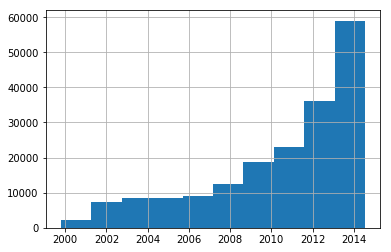

In [7]:
# Распределение отзывов по времени
dataset.reviewTime.hist()

In [8]:
dataset.reviewTime.max()

Timestamp('2014-07-22 00:00:00')

In [9]:
# Среднее количество отзывов на человека
dataset.groupby('reviewerID').size().mean()

7.622587150677038

In [10]:
# Функция очистки текста, удаляем пунктуацию, стоп слова и оставляем стеммы
stopwords_set = stopwords.words('english')
stemmer = SnowballStemmer('english')
def clean_text(text):
    text = text.lower()
    words = word_tokenize(text)    
    words = [stemmer.stem(word) for word in words if (word not in stopwords_set) and (word not in string.punctuation)]   
    return ' '.join(words)

In [11]:
# Объединяем summary и reviewText
dataset['fullText'] = dataset.summary.fillna('').str.cat(dataset.reviewText.fillna(''), ' ')

In [12]:
# Подготавливаем текст
dataset['clearText'] = dataset.fullText.progress_apply(clean_text)

100%|█████████████████████████████████████████████████████████████████████████| 185206/185206 [22:54<00:00, 134.73it/s]


In [13]:
print('Отзывов без summary', dataset.summary.isna().sum())
print('Отзывов без текста', dataset.reviewText.isna().sum())
print('Отзывов одновременно без текста и summary', (dataset.summary.isna() & dataset.reviewText.isna()).sum())

Отзывов без summary 8
Отзывов без текста 40
Отзывов одновременно без текста и summay 0


In [14]:
# Проверяем есть ли отзывы без оценки и текста
(dataset.overall.isna() & dataset.summary.isna() & dataset.reviewText.isna()).sum()

0

In [15]:
# Проверяем есть ли дубликаты
dataset.duplicated(subset=['reviewerID', 'asin']).sum()

0

In [16]:
# Средний рейтинг игр
rating_avg = defaultdict(lambda: 0, (dataset.groupby('asin')['overall'].mean()).to_dict())

In [17]:
# Средний рейтинг игр помноженный на логарифм количества отзывов 
rating_x_popularity = defaultdict(lambda: 0, (dataset.groupby('asin').
                                              progress_apply(lambda x : x['overall'].mean() * len(x))).to_dict())

100%|██████████████████████████████████████████████████████████████████████████| 10672/10672 [00:09<00:00, 1074.59it/s]


In [18]:
[(i, rating_x_popularity[i], rating_avg[i]) for i in sorted(rating_x_popularity, key = rating_x_popularity.get, reverse=True)][0:10]

[('B0015AARJI', 2384.524345397949, 4.585623741149902),
 ('B002VBWIP6', 1859.199935913086, 4.742856979370117),
 ('B000B9RI14', 1636.1073303222656, 4.812080383300781),
 ('B0009VXBAQ', 1570.2507762908936, 4.435736656188965),
 ('B00005NZ1G', 1255.6363334655762, 4.549407005310059),
 ('B001JKTC9A', 1222.6637363433838, 4.794759750366211),
 ('B003ZSP0WW', 1151.094386100769, 4.679245471954346),
 ('B000FQ2D5E', 1128.0000228881836, 4.476190567016602),
 ('B000UW21A0', 1119.0548095703125, 4.371307849884033),
 ('B0029LJIFG', 1102.661973953247, 4.652582168579102)]

5 элементов в топе по рейтингу и популярности вовсе не являются играми. <br>Непонятно нужно ли их включать в модель и рекомендовать.
- B0015AARJI - Джойстик
- B002VBWIP6 - Подписка на Live
- B000B9RI14 - Карты для оплаты в цифровом магазине
- B0009VXBAQ - Приставка Wii
- B003ZSP0WW - Джойстик


In [19]:
dataset[(dataset.asin == 'B0009VXBAQ') & (dataset.overall == 5.0)].reviewText.iloc[4]

"How could you not love this system.  It is very fun for everyone.  My whole family loves playing Wii Sports and Super Mario Galaxy is one of the greatest games I've played in a while."

# Модель для предсказания рейтинга на основе текстового отзыва 

Поскольку у большого количества отзывов (10%) отсутствует оценки, то перед построением рекоммендательной системы имеет смысл построить модель для предсказания оценки на основе текстового отзыва и заполнить пропуски.

In [20]:
# Фильтруем отзывы без оценок
ratings = dataset[~dataset.overall.isna()]

In [21]:
X = ratings['clearText']
y = ratings['overall']
ratings_train, ratings_test, label_train, label_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [22]:
# Если решали задачу регрессии, то нужно привести ответы к категориям
def categorize_answer(y_pred):
    return np.array([min(max(y, min_rating), max_rating) for y in np.round(y_pred)])

def train_classifier(model):
    pipeline = Pipeline([
        # Биграммы незначительно улучшают результат, но значительно увеличивают время обучения
        ('Tf-Idf', TfidfVectorizer(ngram_range=(1, 1), min_df=0.01)),
        ('classifier', model)
    ])
    pipeline.fit(ratings_train, label_train)
    predicted = pipeline.predict(ratings_test)
    answer = categorize_answer(predicted)
    print(metrics.classification_report(label_test, answer))
    print('MAE: ', metrics.mean_absolute_error(label_test, predicted))
    return pipeline

In [23]:
linear_regression_model = train_classifier(LinearRegression())

             precision    recall  f1-score   support

        1.0       0.71      0.11      0.19      5345
        2.0       0.30      0.19      0.23      4921
        3.0       0.31      0.39      0.35     10108
        4.0       0.32      0.61      0.42     19995
        5.0       0.80      0.53      0.64     43445

avg / total       0.59      0.48      0.50     83814

MAE:  0.6738542498363781


In [58]:
logistic_regression_model = train_classifier(LogisticRegression())

             precision    recall  f1-score   support

        1.0       0.60      0.51      0.55      5345
        2.0       0.41      0.10      0.15      4921
        3.0       0.44      0.28      0.34     10108
        4.0       0.48      0.34      0.40     19995
        5.0       0.69      0.90      0.78     43445

avg / total       0.58      0.62      0.59     83814

MAE:  0.5521512


Были использованы простые модели для демонстрации.
Но для таких простых моделей получился довольно неплохой результат, в среднем ошибаемся только на каждом втором отзыве на +-1 балл. 

In [25]:
# Прогнозируем рейтинг и заполняем пропущенные значения
reviews_without_rating = dataset[dataset.overall.isna()]['clearText']
predicted_ratings = logistic_regression_model.predict(reviews_without_rating)
dataset.loc[dataset.overall.isna(), 'overall'] = predicted_ratings

# Рекомендательная система

## Подготовка данных

In [26]:
# Сколько рекомендаций будем делать
recommendation_count = 20

In [27]:
# Обучать будем на отзывах до 2014 года
dataset_train = dataset.loc[dataset.reviewTime < '2014-01-01']

In [28]:
# Валидировать будем на отзывах 2014 года
dataset_test = dataset.loc[dataset.reviewTime >= '2014-01-01']

In [29]:
# Всего пользователей
all_users = dataset.reviewerID.unique()
len(all_users)

24297

In [30]:
# Выберем N случайных пользователей для валидации, не беспокоимся, что они есть и в тесте и в трейне
test_users_count = 1000
test_users = set(dataset['reviewerID'].drop_duplicates().sample(test_users_count, random_state = 42))

In [31]:
# Формируем множество игр которые положительно оценили тестовые пользователи в 2014 году
test_users_dataset = dataset_test[dataset_test.reviewerID.isin(test_users) & (dataset_test.overall > 2.0)]
liked_games = test_users_dataset.groupby(test_users_dataset.reviewerID.astype(object)).apply(lambda x: set(x['asin'])).to_dict()
liked_games = defaultdict(set, liked_games)

In [32]:
# Отображение из внешнего идентификатора во внутренний
user_id_to_cat = dict(zip(
    dataset_train['reviewerID'].cat.categories,
    range(len(dataset_train['reviewerID'].cat.categories))
))
element_id_to_cat = dict(zip(
    dataset_train['asin'].cat.categories,
    range(len(dataset_train['asin'].cat.categories))
))

In [33]:
# Множество игр которые точно не нужно рекомендовать
filtered_games = defaultdict(set)
for user_id, element_id in tqdm(dataset_train.loc[:, ['reviewerID', 'asin']].values):
    filtered_games[user_id].add(element_id)
filtered_games_cat = defaultdict(set, { user_id_to_cat[k]: [element_id_to_cat.get(x, None) for x in v] for k, v in filtered_games.items()})

100%|███████████████████████████████████████████████████████████████████████| 163922/163922 [00:01<00:00, 96788.86it/s]


In [34]:
# Качество будем оценивать простой точностью
def calculate_precision(recommended, liked):
    if len(liked) == 0:
        return 0.0
    relevant_count = 0.0
    for item in recommended:
        if item in liked:
            relevant_count += 1.0
    return relevant_count / min(len(liked), recommendation_count)

In [35]:
# Функция вызывает модель для тестовых пользователей и оценивает результат
def recommend(model_recommend_func):
    precision_sum = 0.0
    relevant_count = 0
    user_count = 0
    for test_user_id in test_users:
        # На случай если пользователя не было в трейне
        try:
            user_cat = user_id_to_cat[test_user_id]
        except LookupError:
            continue

        user_count += 1
        recommended = model_recommend_func(user_cat)        
        precision_sum += calculate_precision(recommended, liked_games[test_user_id])

    print('Mean precision: ', precision_sum / user_count)

## Модели независимые от пользователя

### Средний рейтинг

In [36]:
# Возвращаем топ N игр по среднему рейтингу
top_rating_avg = sorted(rating_avg, key = rating_avg.get, reverse=True)
def rating_avg_recommend(user_cat):
    user_id = dataset_train.reviewerID.cat.categories[user_cat]
    user_filtered_games = filtered_games[user_id]
    return islice((i for i in top_rating_avg if i not in user_filtered_games), recommendation_count)

In [37]:
print('Средний рейтинг:')
recommend(rating_avg_recommend)

Средний рейтинг:
Mean precision:  0.00012222222222222221


### Средний рейтинг и популярность

In [38]:
# Возвращаем топ N игр по среднему рейтингу и популярности
top_rating_x_popularity = sorted(rating_x_popularity, key = rating_x_popularity.get, reverse=True)
def rating_popularity_recommend(user_cat):
    user_id = dataset_train.reviewerID.cat.categories[user_cat]
    user_filtered_games = filtered_games[user_id]
    return islice((i for i in top_rating_x_popularity if i not in user_filtered_games), recommendation_count)

In [39]:
print('Средний рейтинг и популярность:')
recommend(rating_popularity_recommend)

Средний рейтинг и популярность:
Mean precision:  0.0068916666666666675


## Простые модели основанные на схожести пользователей

In [40]:
# Строим матрицу оценок
ratings_matrix = sp.coo_matrix(
    (dataset_train['overall'],
        (
            dataset_train['asin'].cat.codes.copy(),
            dataset_train['reviewerID'].cat.codes.copy()
        )
    )
)

ratings_matrix = ratings_matrix.tocsr()
ratings_matrix_T = ratings_matrix.T.tocsr()

In [41]:
sparsity = ratings_matrix.nnz / (ratings_matrix.shape[0] * ratings_matrix.shape[1])
print('Sparsity: %.6f' % sparsity)

Sparsity: 0.000636


In [42]:
def implicit_model_recommend(user_cat, model, user_items):
    recommended_cat = model.recommend(
                user_cat,
                user_items,
                N = recommendation_count,
                filter_already_liked_items = True,
                filter_items= filtered_games_cat.get(user_cat, set())
            )
    recommended = [dataset_train['asin'].cat.categories[i] for i, _ in recommended_cat]
    return recommended

### BM25

In [43]:
bm25_model = BM25Recommender(K = 60)
bm25_model.fit(ratings_matrix)

100%|█████████████████████████████████████████████████████████████████████████| 10609/10609 [00:00<00:00, 48647.38it/s]


In [44]:
def bm25_recommend(user_cat):
    return implicit_model_recommend(user_cat, bm25_model, ratings_matrix_T)

In [45]:
print('Схожесть BM25:')
recommend(bm25_recommend)

Схожесть BM25:
Mean precision:  0.014076129426129427


### Cosine

In [46]:
cosine_model = CosineRecommender(K = 120)
cosine_model.fit(ratings_matrix)

100%|█████████████████████████████████████████████████████████████████████████| 10609/10609 [00:00<00:00, 43685.95it/s]


In [47]:
def cosine_recommend(user_cat):
    return implicit_model_recommend(user_cat, cosine_model, ratings_matrix_T)

In [48]:
print('Схожесть Cosine:')
recommend(cosine_recommend)

Схожесть Cosine:
Mean precision:  0.012730494505494506


## Модели основанные на разложении матрицы

### ALS

In [49]:
# Строим матрицу оценок
als_ratings_matrix = sp.coo_matrix(
    (dataset_train['overall'] - 2,
        (
            dataset_train['asin'].cat.codes.copy(),
            dataset_train['reviewerID'].cat.codes.copy()
        )
    )
)

als_ratings_matrix = als_ratings_matrix.tocsr()
als_ratings_matrix_T = als_ratings_matrix.T.tocsr()

In [50]:
als_model = AlternatingLeastSquares(factors=5)
als_model.fit(als_ratings_matrix)

100%|████████████████████████████████████████████████████████████████████████████████| 15.0/15 [00:00<00:00, 19.46it/s]


In [51]:
def als_recommend(user_cat):
    return implicit_model_recommend(user_cat, als_model, als_ratings_matrix_T)

In [52]:
print('ALS:')
recommend(als_recommend)

ALS:
Mean precision:  0.01250873015873016


### WARP

In [53]:
fm_ratings_matrix = als_ratings_matrix_T
fm_model = LightFM(no_components=39, loss='warp', random_state=42)
fm_model.fit(fm_ratings_matrix, epochs=5)

In [54]:
items_count = len(dataset_train.asin.unique())
def warp_recommend(user_cat):
    scores = fm_model.predict(
        user_cat,
        np.arange(items_count)
    )
    
    user_filtered_games_cat = filtered_games_cat[user_cat]
    recommended = [dataset_train['asin'].cat.categories[i] for i in np.argsort(-scores)[:recommendation_count + len(user_filtered_games_cat)] if i not in user_filtered_games_cat][:recommendation_count]
    return recommended

In [55]:
print('WARP:')
recommend(warp_recommend)

WARP:
Mean precision:  0.017482081807081808


## Результаты

In [56]:
print('Средний рейтинг:')
recommend(rating_avg_recommend)
print('Средний рейтинг и популярность:')
recommend(rating_popularity_recommend)
print('Схожесть Cosine:')
recommend(cosine_recommend)
print('Схожесть BM25:')
recommend(bm25_recommend)
print('ALS:')
recommend(als_recommend)
print('WARP:')
recommend(warp_recommend)

Средний рейтинг:
Mean precision:  0.00012222222222222221
Средний рейтинг и популярность:
Mean precision:  0.0068916666666666675
Схожесть Cosine:
Mean precision:  0.012730494505494506
Схожесть BM25:
Mean precision:  0.014076129426129427
ALS:
Mean precision:  0.01250873015873016
WARP:
Mean precision:  0.017482081807081808


В качестве базовой модели используется топ по среднему рейтингу и популярности. Простая модель, основанная на схожести вкусов пользователей BM25, превосходит базовую в 2 раза, а модель, основанная на скрытых факторах WARP, превосходит базовую в 2.5 раза. 